## **This script will evaluate the membrane passive propertieis of CRH cells in the BNST between a Sapap3 KO mouse line and a WT line**
*Written by Omer Richmond* 
*Yizhar Lab*
*Weizmann institute* 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyabf
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pandas as pd

# Set Calibri font for all plots
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.sans-serif'] = ['Calibri', 'Arial', 'DejaVu Sans', 'Liberation Sans']

In [2]:
# * I would like to plot firing rate as a function of input current* 
# * I would like to plot one example from every condition for each protocol 
# * amplitude as a function of stimulation current
# * number of EPSCs and number of IPSCs
# * Max amplitude of EPSC or IPSC in every cell
# (Show also a short sample of that raw trace)
# * Scheme of injection site 
# scheme of breeding metohd 
# image of epxression in the confocal 
# image of expression under the 1 p 
# image of cell being patched (or maybe just a scheme) 
# Output gain (Hz/pA)

### *Example of an IV curve*

C:\Users\omerich.WISMAIN\AppData\Local\Temp\ipykernel_30820\1966796777.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


Text(0.5, 0, 'Time (s)')

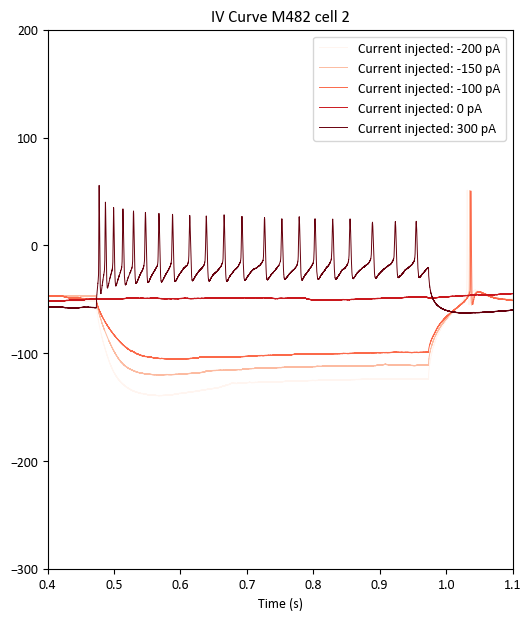

In [7]:
iv_path = r"""Z:\Omer\Ph.D\Project- Uri's sapap3ko_vs_wt_crh_cells\Data\14.07.25\2025_07_14_0006.abf"""
abf = pyabf.ABF(iv_path)
import matplotlib.cm as cm
colormap = 'Reds'  # You can change this to any colormap you prefer
cmap = cm.get_cmap(colormap)
plt.figure(figsize=(6, 7))
plt.title("IV Curve M482 cell 2")
sweeps_to_plot =[0,1,2,4,10]
for idx, sweep in enumerate(sweeps_to_plot):
    abf.setSweep(sweep)
    plt.plot(abf.sweepX,abf.sweepY,label=f'Current injected: {(-200)+(sweep)*50} pA',color=cmap(idx / (len(sweeps_to_plot)-1)),linewidth=0.7)
plt.legend()
plt.ylim(-300, 200)
plt.xlim(0.4, 1.1)
plt.xlabel("Time (s)")

In [ ]:
def peaks_finder(trace_filtred,thresh_min,thresh_max,thresh_prominence,fs):    
    fs = 50000
    peaks_signal = trace_filtred[497*50:(497*50)+25000] # 497 ms from recording start till stim on and 50 samples per ms] 

    # Event window parameters
    event_no = 0  # Event viewer: 0 is the first event
    pretrigger_window = (2 * fs)/1000  # Pre-event time window in ms
    posttrigger_window = (5 * fs)/1000  # Post-event time window in ms
    std_trace = np.std(peaks_signal)
    # Set parameters of the Find peaks function

    thresh_min_width = 0.1 * (fs/1000)
    
    # Find peaks function
    peaks, peaks_dict = find_peaks(-peaks_signal, 
            height=(thresh_min, thresh_max),  # Min and max thresholds to detect peaks.
            threshold=None,  # Min and max vertical distance to neighboring samples.
            distance=None,  # Min horizontal distance between peaks.
            prominence=thresh_prominence,  # Vertical distance between the peak and lowest contour line.
            width=thresh_min_width,  # Min required width (in bins). E.g. For 10Khz, 10 bins = 1 ms.
            wlen=None,  # Window length to calculate prominence.
            rel_height=0.5,  # Relative height at which the peak width is measured.
            plateau_size=None)
    
    # Create table with results
    table = pd.DataFrame(columns = ['event', 'peak_index', 
                                    'peak_time_s',
                                    'event_window_start', 'event_window_end',
                                    'peak_amp', 'width_ms', 
                                    'inst_freq', 'isi_s', 
                                    'area', 'decay_tau_log', 
                                    'decay_tau_exp', 'rise_tau_exp','rise_half_amp_ms','decay_half_amp_ms'])
    
    table.event = np.arange(1, len(peaks) + 1)
    table.peak_index = peaks
    table.peak_time_s = peaks / fs  # Divided by fs to get s
    table.event_window_start = peaks_dict['left_ips'] - pretrigger_window
    table.event_window_end = peaks_dict['right_ips'] + posttrigger_window
    table.peak_amp = peaks_dict['peak_heights']  # height parameter is needed
    table.width_ms = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
    
    # Additional parameters (remember to add the columns to the dataframe)
    table.rise_half_amp_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
    table.decay_half_amp_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
    
    # Calculations based on the parameters above
    table.inst_freq = np.insert((1 / (np.array(table.peak_index[1:]) -
                                    np.array(table.peak_index[:-1])) * fs), 
                                0, np.nan) 
    
    table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
    
    for i, event in table.iterrows():
        
        # Event area as absolute value (abs)
        individual_event = peaks_signal[int(event.event_window_start) : int(event.event_window_end)]
        table.loc[i, 'area'] = abs(round(individual_event.sum()/(fs/1000), 2))  # pA x ms
        
        # Decay tau from logistic regression
        decay_tau = abs(peaks_signal[int(event.peak_index) : int(event.event_window_end)])
        decay_tau_log = np.log(decay_tau)
        decay_width = int(len(decay_tau))
        decay_width_array = list(range(0, decay_width))
        slope, _ = np.polyfit(decay_width_array, decay_tau_log, 1)
        tau = -1 / slope
        table.loc[i, 'decay_tau_log'] = tau/(fs/1000) 
    
        # Decay tau from monoexponential fitting
        decay_tau = peaks_signal[int(event.peak_index) : int(event.event_window_end)]
        decay_width = int(len(decay_tau))
        decay_width_array = list(range(0, decay_width))
        a_initial = 200
        b_initial = 0.1
        # popt: optimal values for the parameters, pcov: estimated covariance of popt
        popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                            decay_width_array, decay_tau, 
                            p0=(a_initial, b_initial), 
                            maxfev=2000)  # maxfev: number of iterations
        a = popt[0]  
        b = popt[1]      
        table.loc[i, 'decay_tau_exp'] = abs((1/b)/(fs/1000))
        
        # Rise tau from monoexponential fitting
        rise_tau = peaks_signal[int(event.event_window_start):int(event.peak_index)]
        rise_width = int(len(rise_tau))
        rise_width_array = list(range(0, rise_width))
        a_initial = 200
        b_initial = 0.1
        # popt: optimal values for the parameters, pcov: estimated covariance of popt
        popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                            rise_width_array, rise_tau, 
                            p0=(a_initial, b_initial), 
                            maxfev=2000)  # maxfev: number of iterations
        a = popt[0]  
        b = popt[1]      
        table.loc[i, 'rise_tau_exp'] = abs((1/b)/(fs/1000))
    

    fig = plt.figure(figsize=(18,4))
    gridspec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])

    # Plot 1: Detected events in the trace
    ax1 = fig.add_subplot(gridspec[0])  # gridspec specifies the ratio between plots
    ax1.set_title("Events detection")   
    ax1.plot(peaks_signal)
    ax1.plot(peaks, peaks_signal[peaks], "r.")
    for i, txt in enumerate(table.event):
        ax1.annotate(table.event[i], (peaks[i], peaks_signal[peaks][i]))
    ax1.set_xlabel("Time bin")
    ax1.set_ylabel("Current (pA)")
    plt.ylim([-150,10])
    # ax1.axes.set_xlim(4000, 10000)  # OptionaL: Zoom in the trace

    # Plot 2: Event viewer
    ax2 = fig.add_subplot(gridspec[1]) 
    ax2.set_title("Event viewer")
    ax2.plot(peaks_signal, "gray")
    ax2.plot(peaks, peaks_signal[peaks], "r.")
    ax2.set_xlabel("Time bin")
    ax2.set_ylabel("Current (pA)")
    # Event time window
    ax2.set_xlim(table.event_window_start[event_no], table.event_window_end[event_no]) 
    # Labeling the event
    line, = ax2.plot(peaks, peaks_signal[peaks], "r.") 
    line.set_label(table.event[event_no]) 
    ax2.legend()
                
        # Show graph and table

    table.round(3)
    plt.show()
    return table # round: display of decimal numbers in the table

  Sweep 0: No events found or error processing - skipping '2025_07_14_0000_sweep_0'
  Sweep 1: No events found or error processing - skipping '2025_07_14_0000_sweep_1'
  Sweep 2: No events found or error processing - skipping '2025_07_14_0000_sweep_2'
  Sweep 3: No events found or error processing - skipping '2025_07_14_0000_sweep_3'
  Sweep 4: No events found or error processing - skipping '2025_07_14_0000_sweep_4'


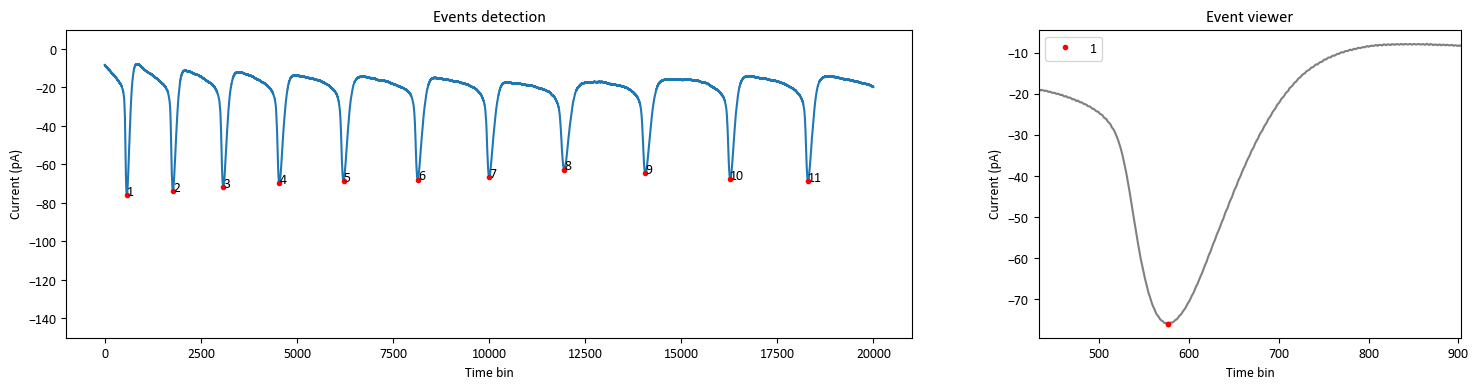

  Sweep 5: Found 11 events - stored as '2025_07_14_0000_sweep_5'
  Sweep 6: No events found or error processing - skipping '2025_07_14_0000_sweep_6'


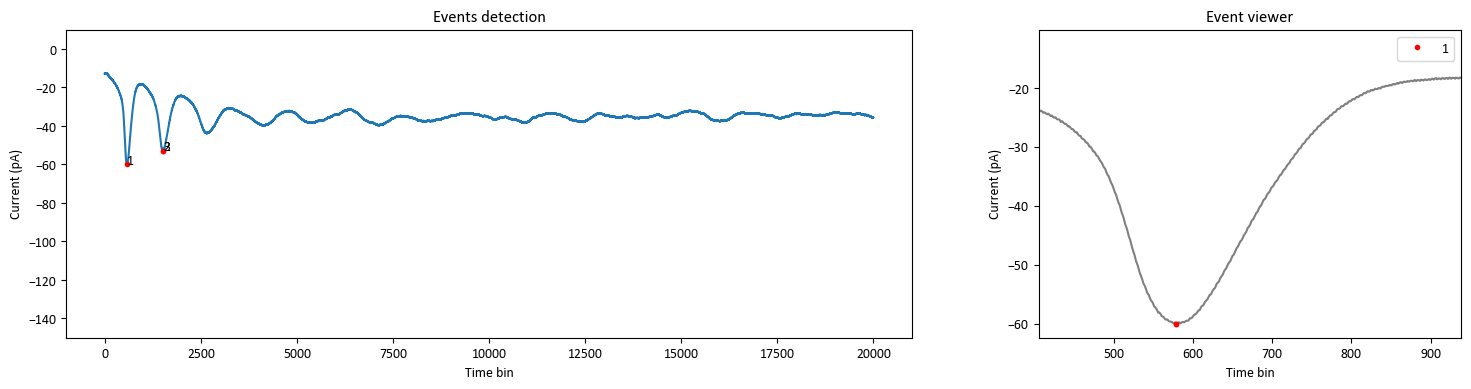

  Sweep 7: Found 3 events - stored as '2025_07_14_0000_sweep_7'


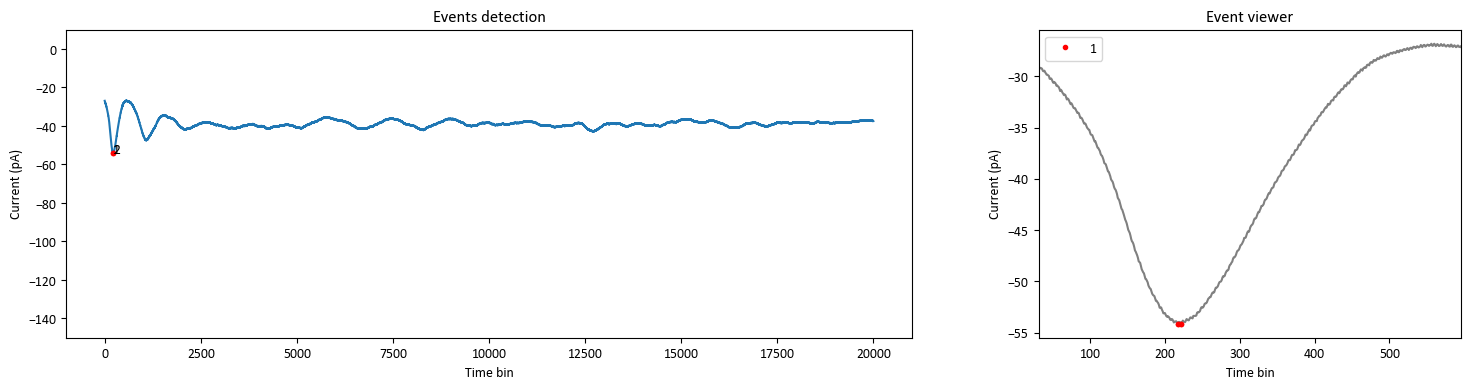

  Sweep 8: Found 2 events - stored as '2025_07_14_0000_sweep_8'
  Sweep 9: No events found or error processing - skipping '2025_07_14_0000_sweep_9'
  Sweep 10: No events found or error processing - skipping '2025_07_14_0000_sweep_10'
  Sweep 11: No events found or error processing - skipping '2025_07_14_0000_sweep_11'
  Sweep 12: No events found or error processing - skipping '2025_07_14_0000_sweep_12'
  Sweep 13: No events found or error processing - skipping '2025_07_14_0000_sweep_13'
  Sweep 0: No events found or error processing - skipping '2025_07_14_0006_sweep_0'
  Sweep 1: No events found or error processing - skipping '2025_07_14_0006_sweep_1'
  Sweep 2: No events found or error processing - skipping '2025_07_14_0006_sweep_2'
  Sweep 3: No events found or error processing - skipping '2025_07_14_0006_sweep_3'
  Sweep 4: No events found or error processing - skipping '2025_07_14_0006_sweep_4'


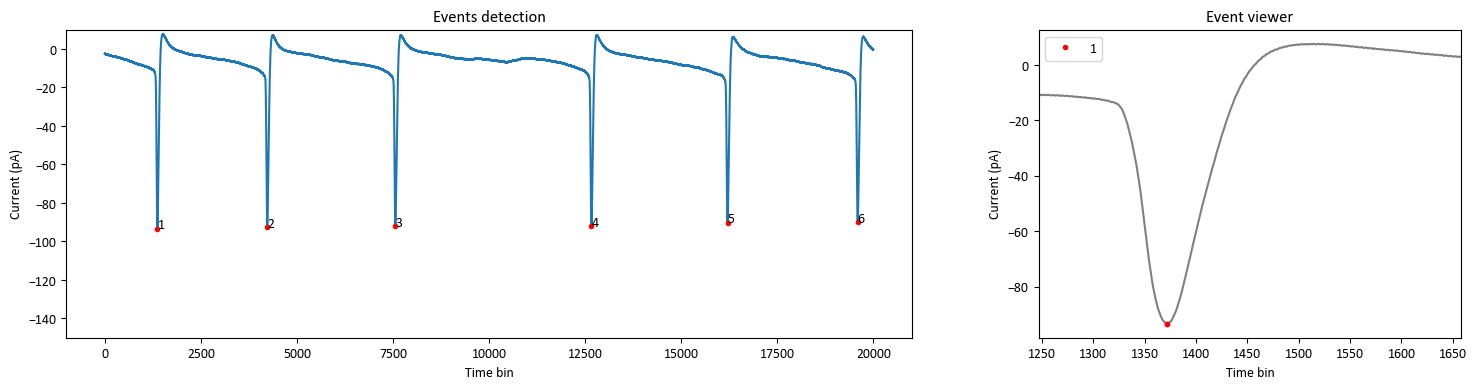

  Sweep 5: Found 6 events - stored as '2025_07_14_0006_sweep_5'


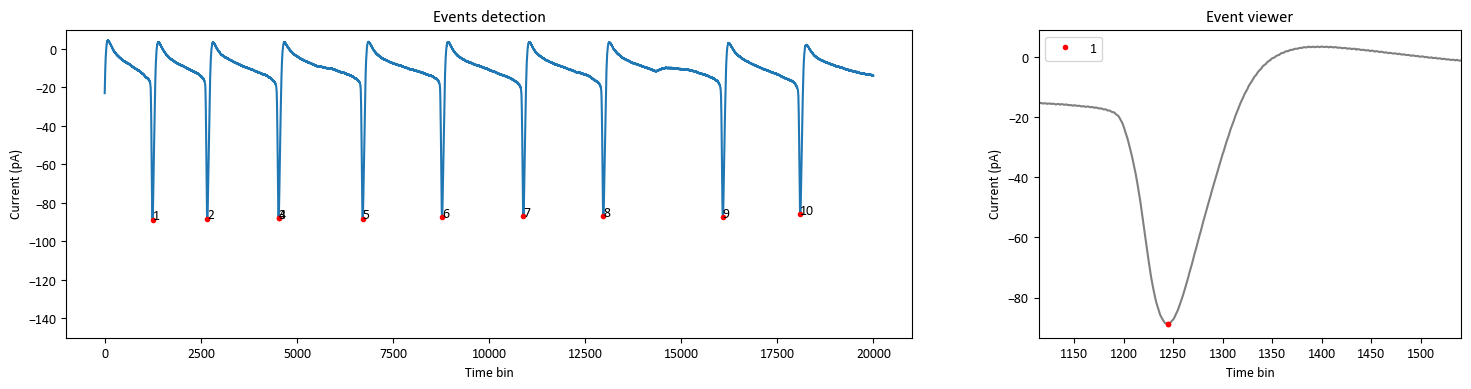

  Sweep 6: Found 10 events - stored as '2025_07_14_0006_sweep_6'


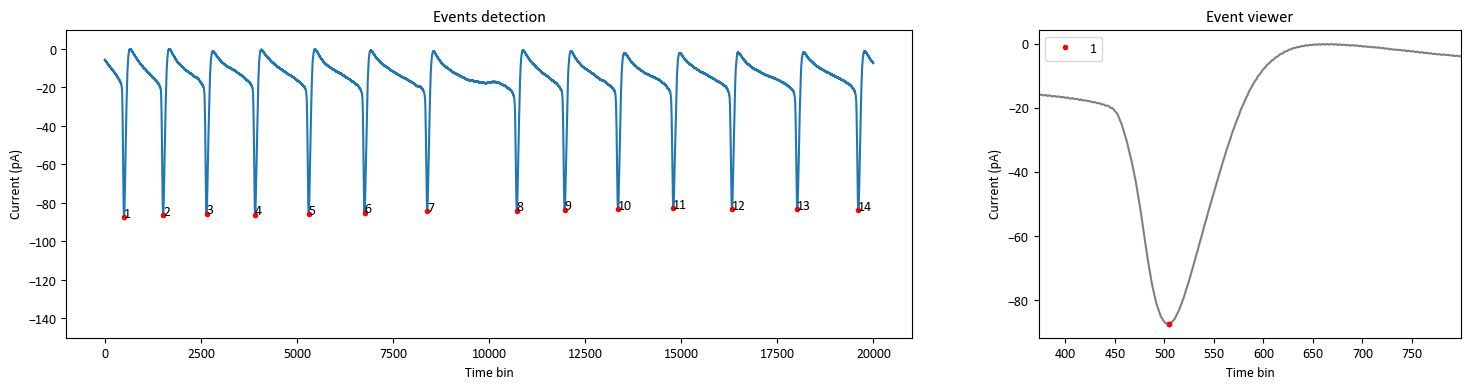

  Sweep 7: Found 14 events - stored as '2025_07_14_0006_sweep_7'


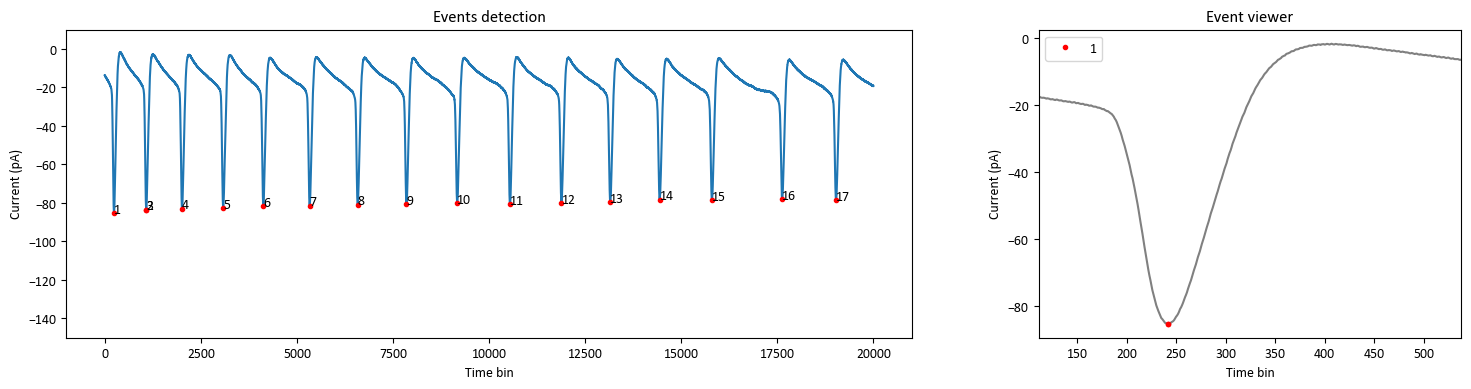

  Sweep 8: Found 17 events - stored as '2025_07_14_0006_sweep_8'
  Sweep 9: No events found or error processing - skipping '2025_07_14_0006_sweep_9'


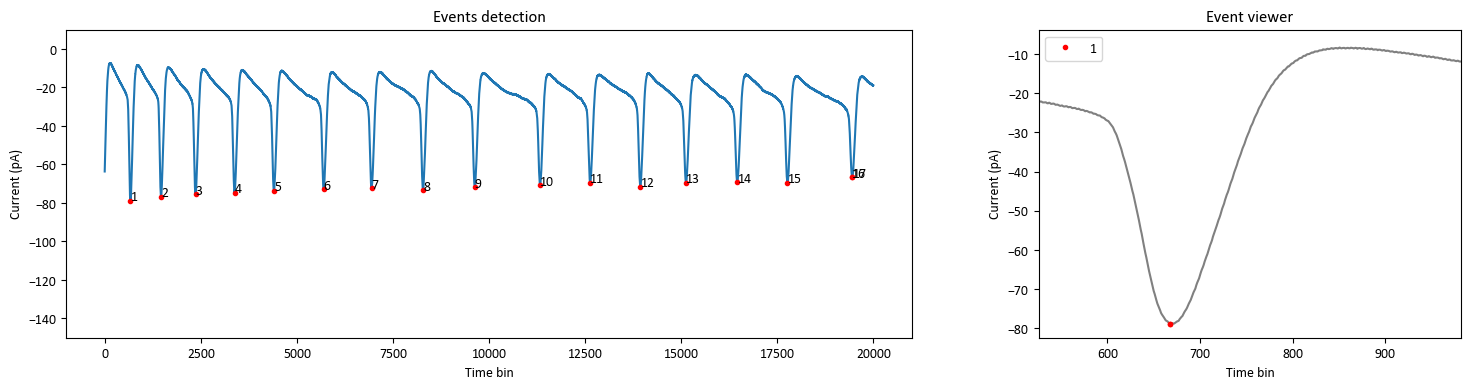

  Sweep 10: Found 17 events - stored as '2025_07_14_0006_sweep_10'


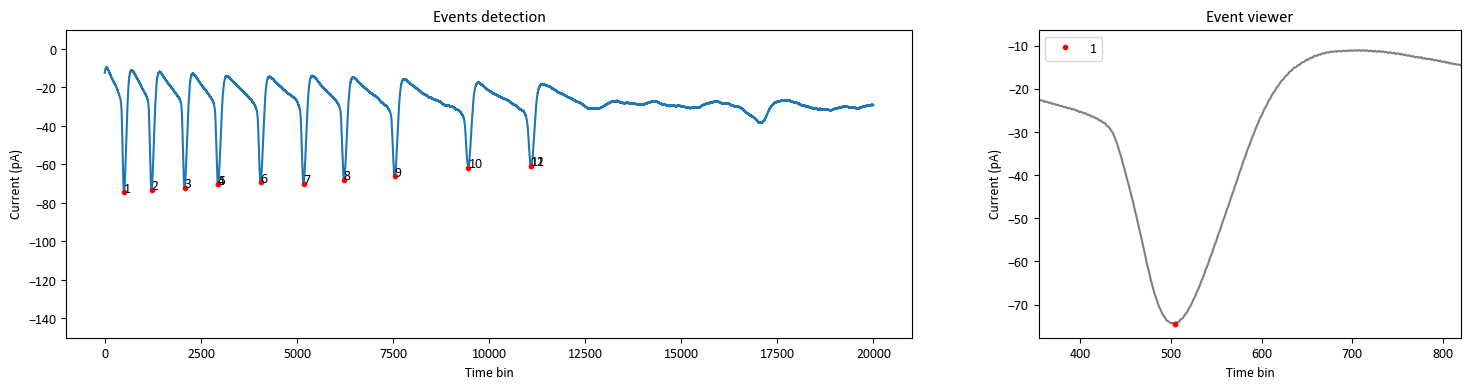

  Sweep 11: Found 12 events - stored as '2025_07_14_0006_sweep_11'


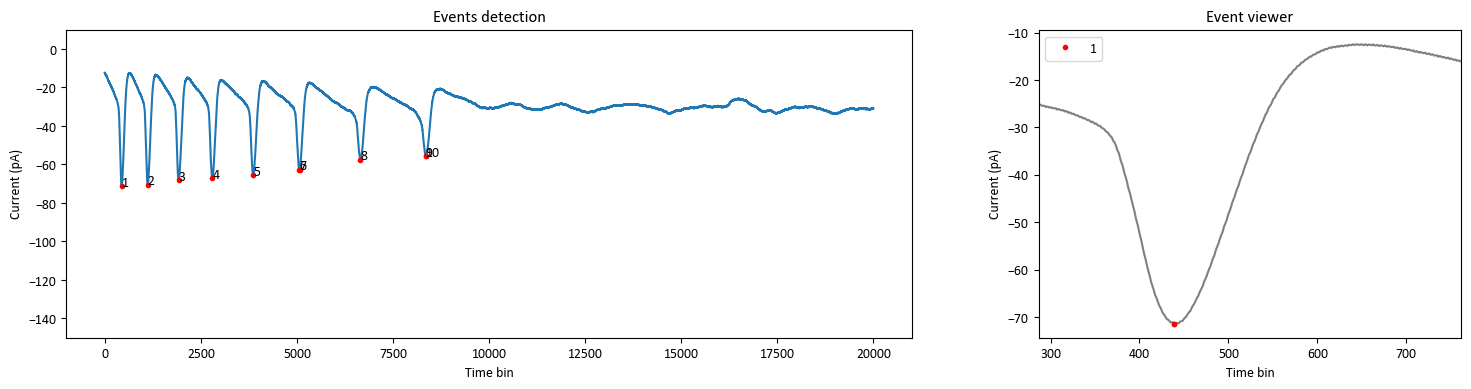

  Sweep 12: Found 10 events - stored as '2025_07_14_0006_sweep_12'


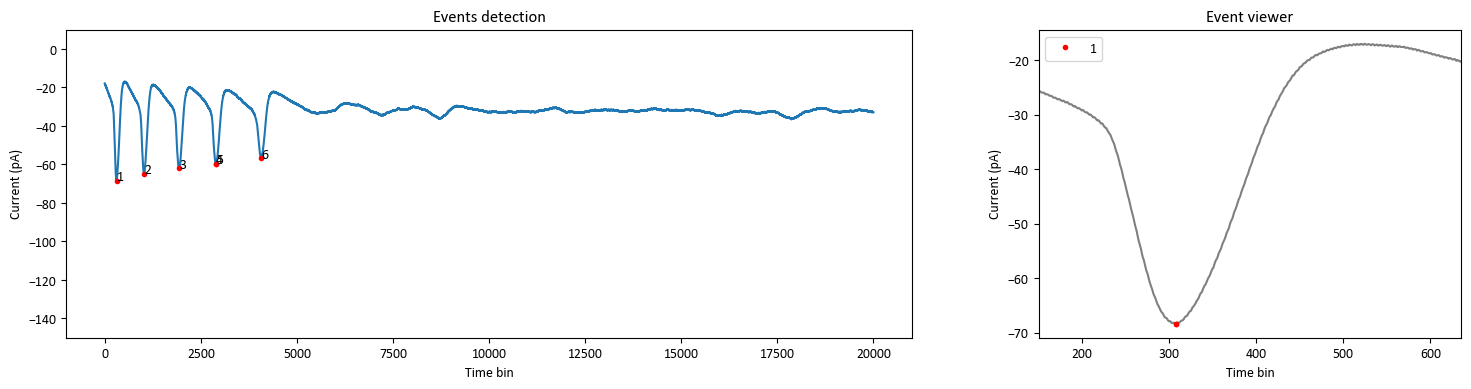

  Sweep 13: Found 6 events - stored as '2025_07_14_0006_sweep_13'
  Sweep 0: No events found or error processing - skipping '2025_07_14_0013_sweep_0'
  Sweep 1: No events found or error processing - skipping '2025_07_14_0013_sweep_1'
  Sweep 2: No events found or error processing - skipping '2025_07_14_0013_sweep_2'
  Sweep 3: No events found or error processing - skipping '2025_07_14_0013_sweep_3'
  Sweep 4: No events found or error processing - skipping '2025_07_14_0013_sweep_4'


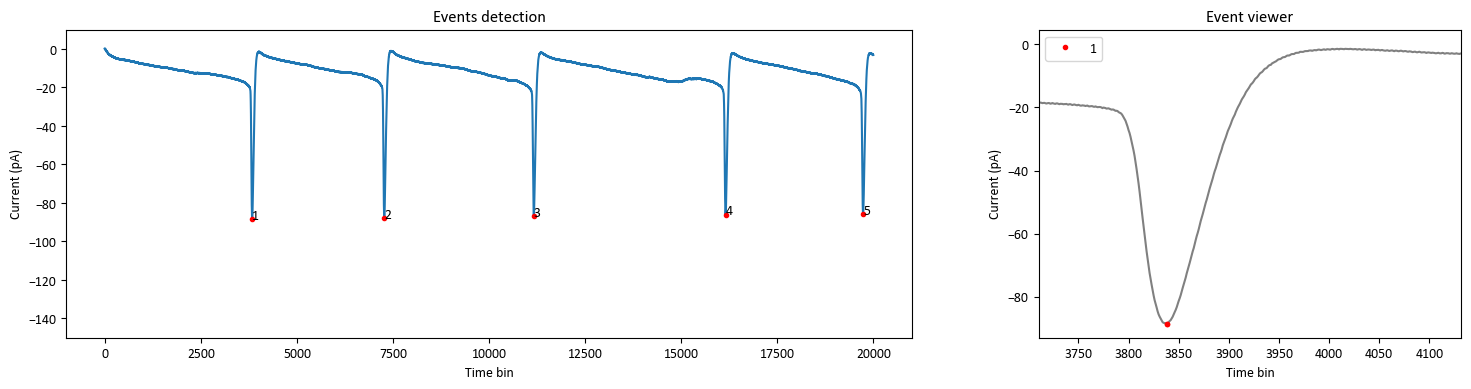

  Sweep 5: Found 5 events - stored as '2025_07_14_0013_sweep_5'


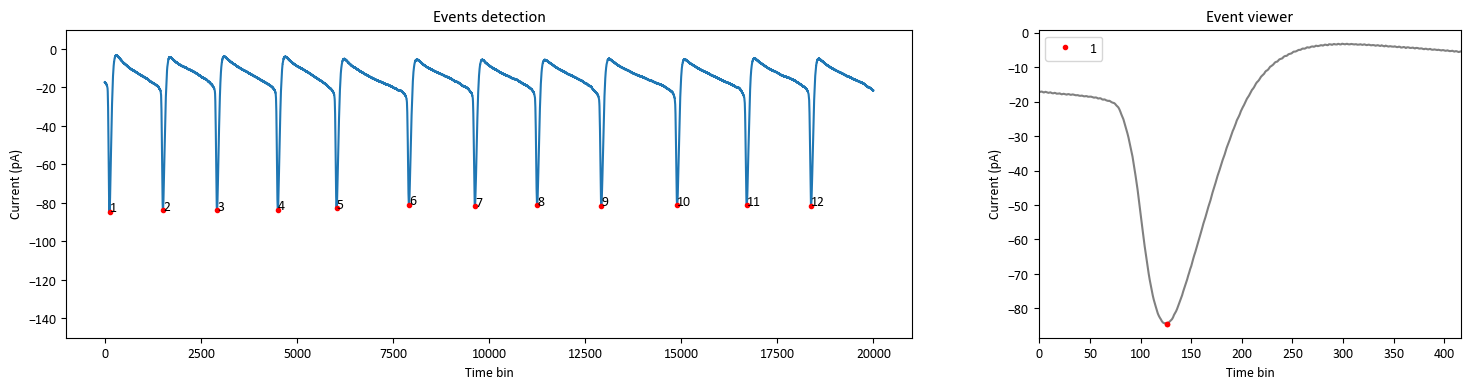

  Sweep 6: Found 12 events - stored as '2025_07_14_0013_sweep_6'


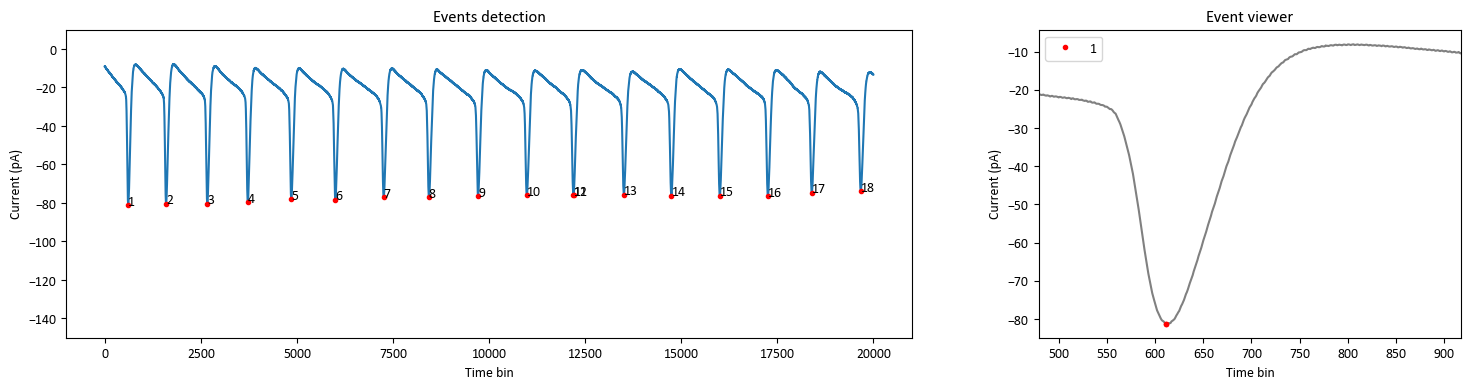

  Sweep 7: Found 18 events - stored as '2025_07_14_0013_sweep_7'


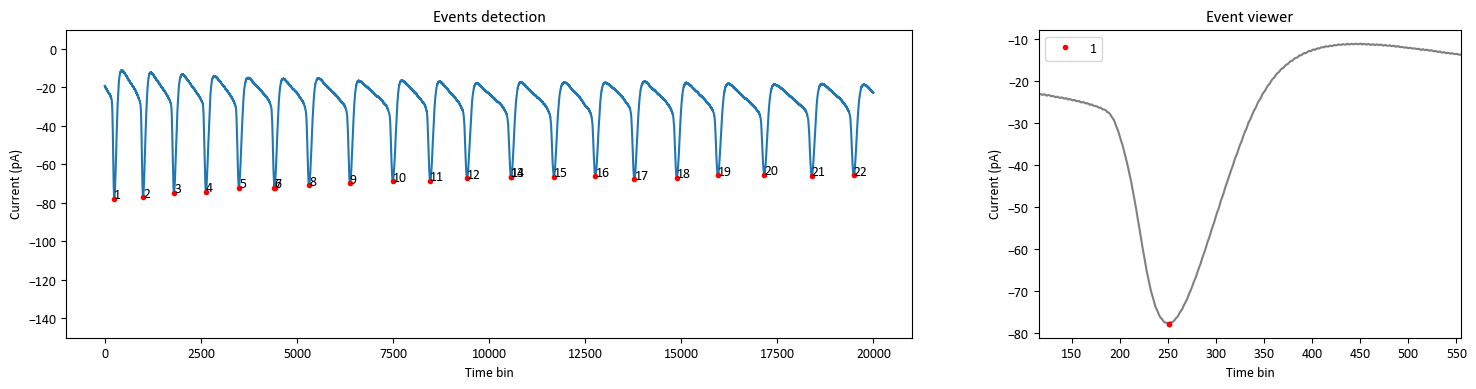

  Sweep 8: Found 22 events - stored as '2025_07_14_0013_sweep_8'
  Sweep 9: No events found or error processing - skipping '2025_07_14_0013_sweep_9'


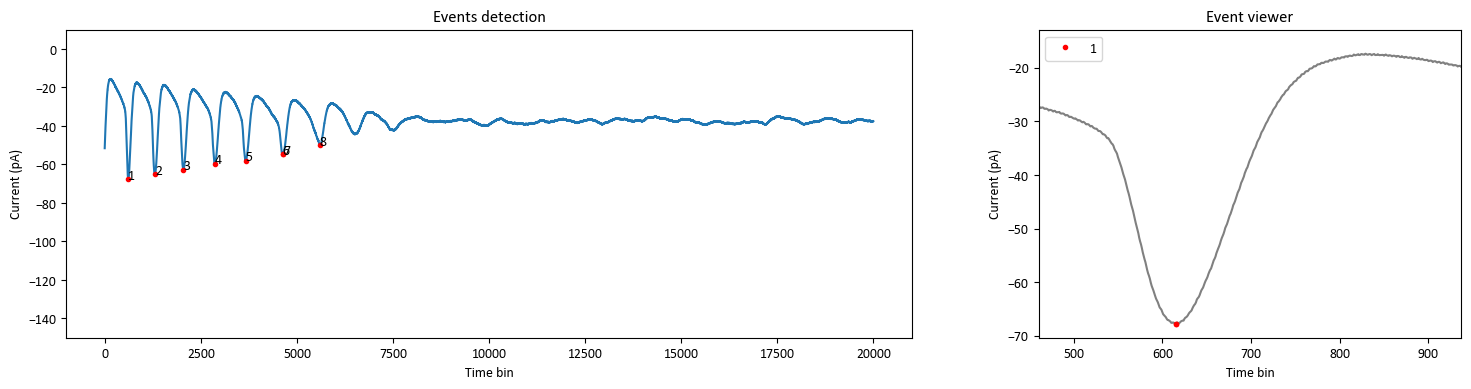

  Sweep 10: Found 8 events - stored as '2025_07_14_0013_sweep_10'


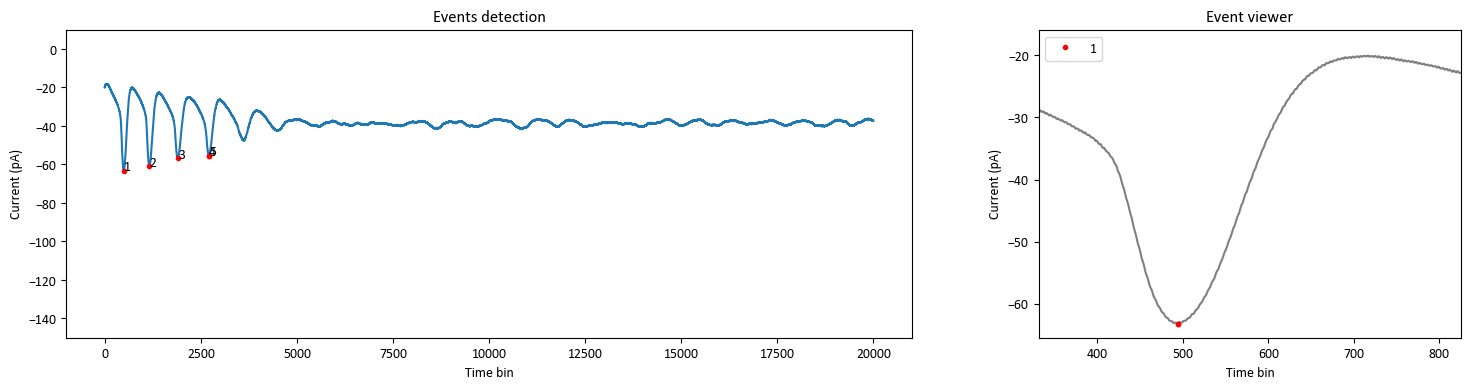

  Sweep 11: Found 5 events - stored as '2025_07_14_0013_sweep_11'


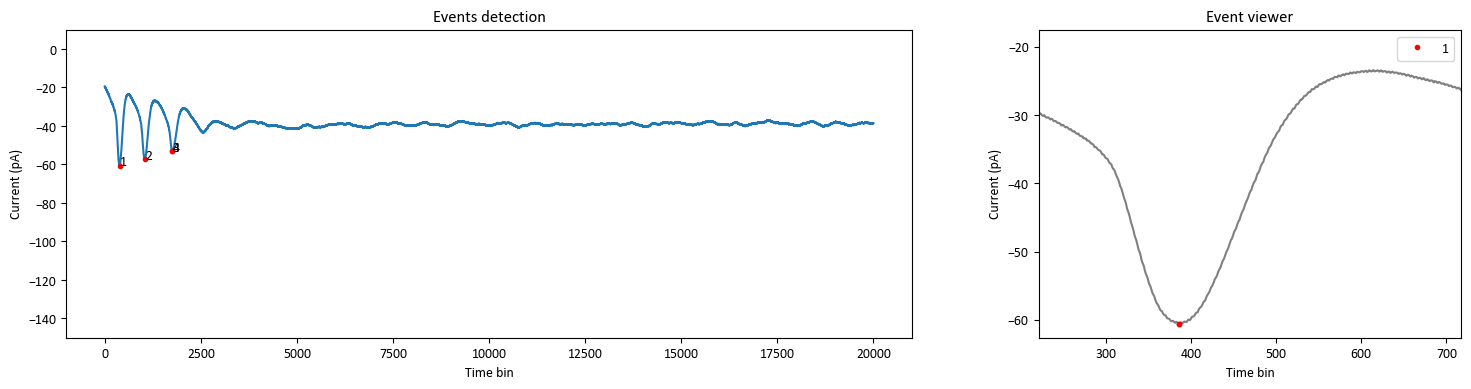

  Sweep 12: Found 4 events - stored as '2025_07_14_0013_sweep_12'


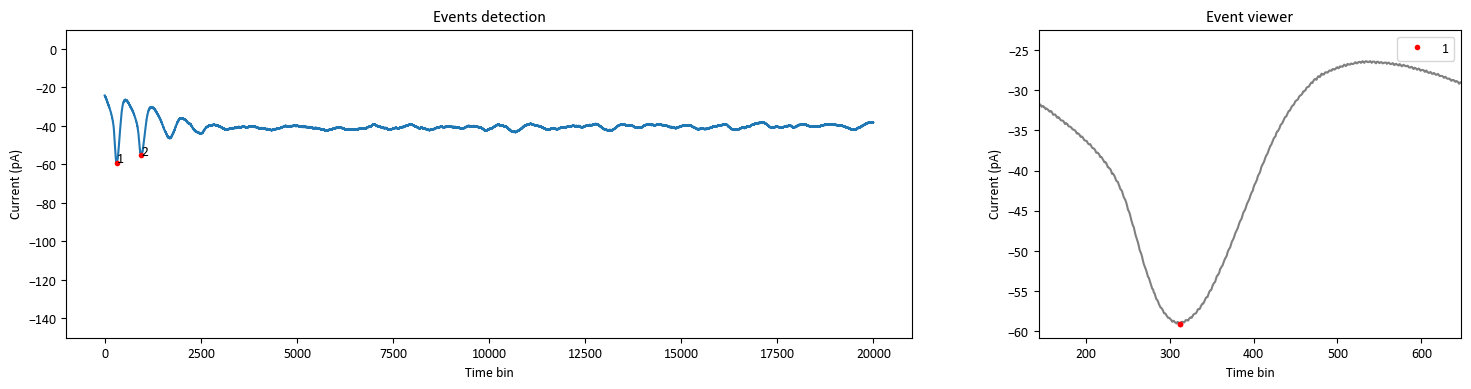

  Sweep 13: Found 2 events - stored as '2025_07_14_0013_sweep_13'
  Sweep 0: No events found or error processing - skipping '2025_07_14_0033_sweep_0'
  Sweep 1: No events found or error processing - skipping '2025_07_14_0033_sweep_1'
  Sweep 2: No events found or error processing - skipping '2025_07_14_0033_sweep_2'
  Sweep 3: No events found or error processing - skipping '2025_07_14_0033_sweep_3'


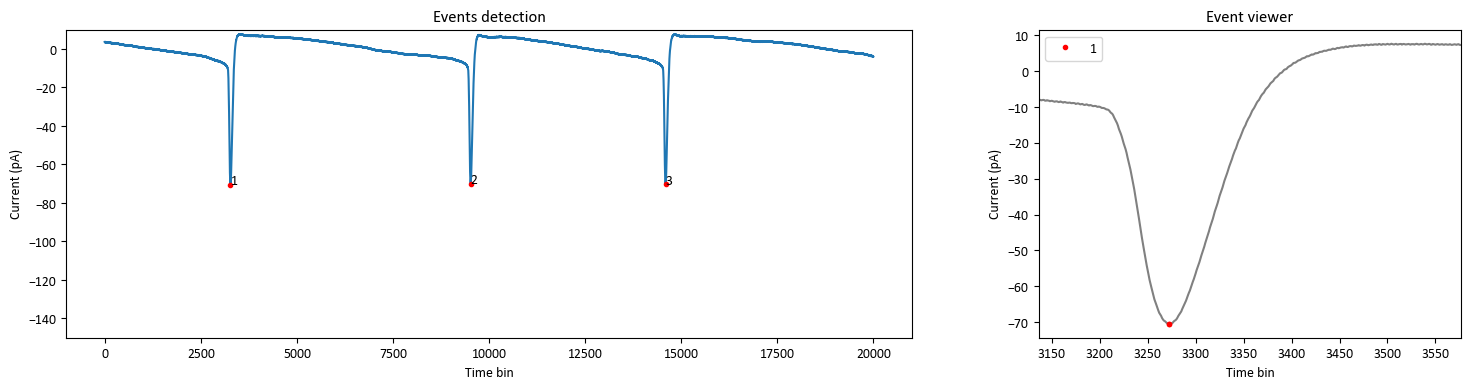

  Sweep 4: Found 3 events - stored as '2025_07_14_0033_sweep_4'


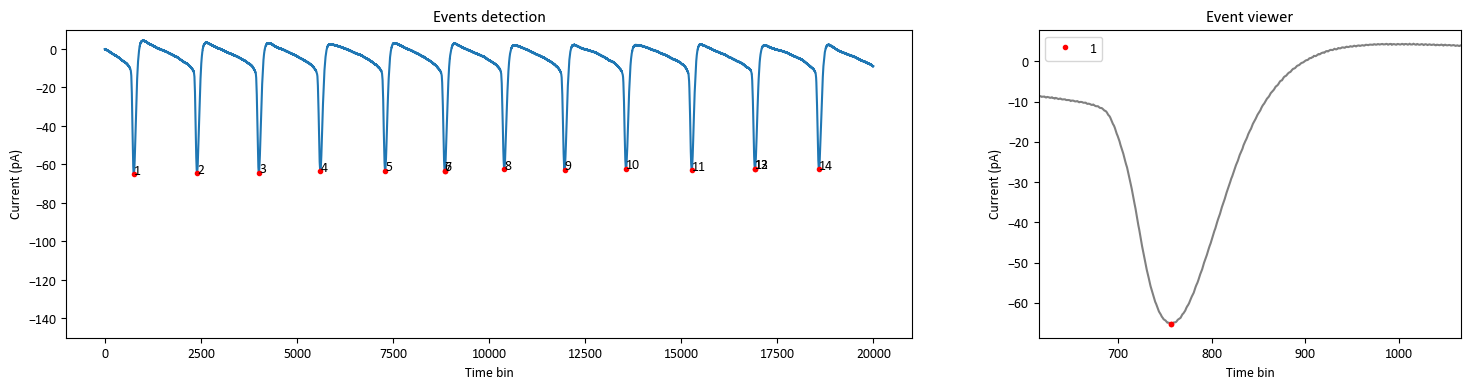

  Sweep 5: Found 14 events - stored as '2025_07_14_0033_sweep_5'


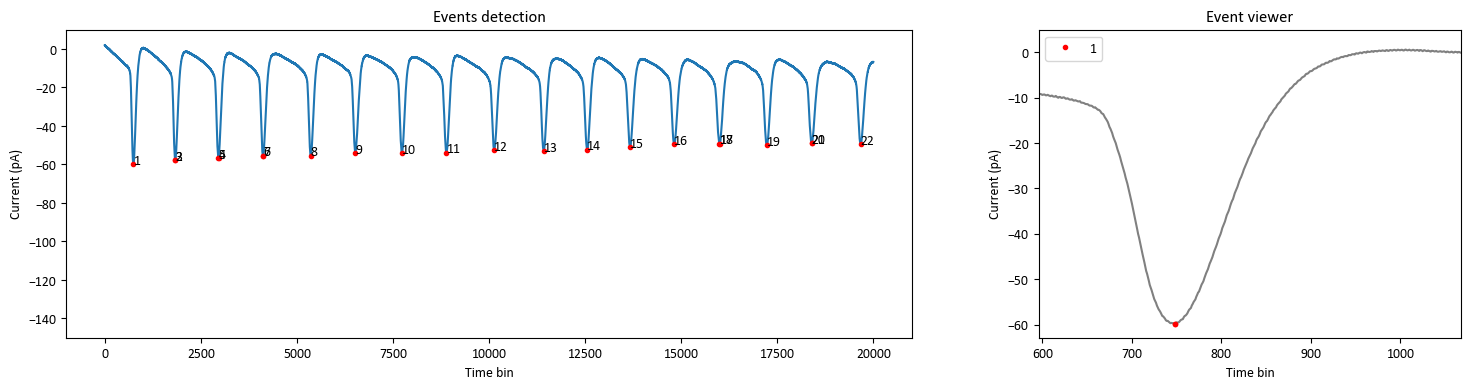

  Sweep 6: Found 22 events - stored as '2025_07_14_0033_sweep_6'


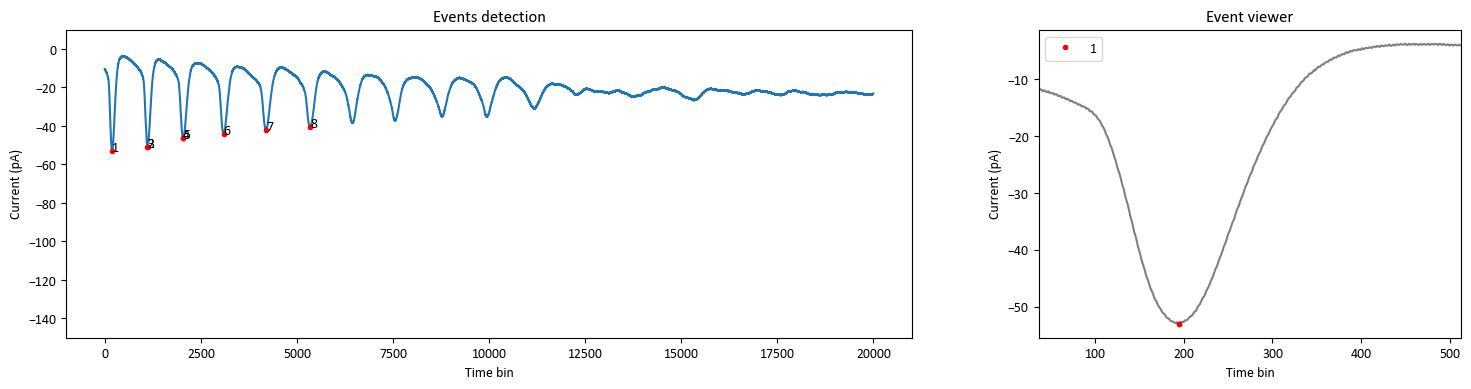

  Sweep 7: Found 8 events - stored as '2025_07_14_0033_sweep_7'


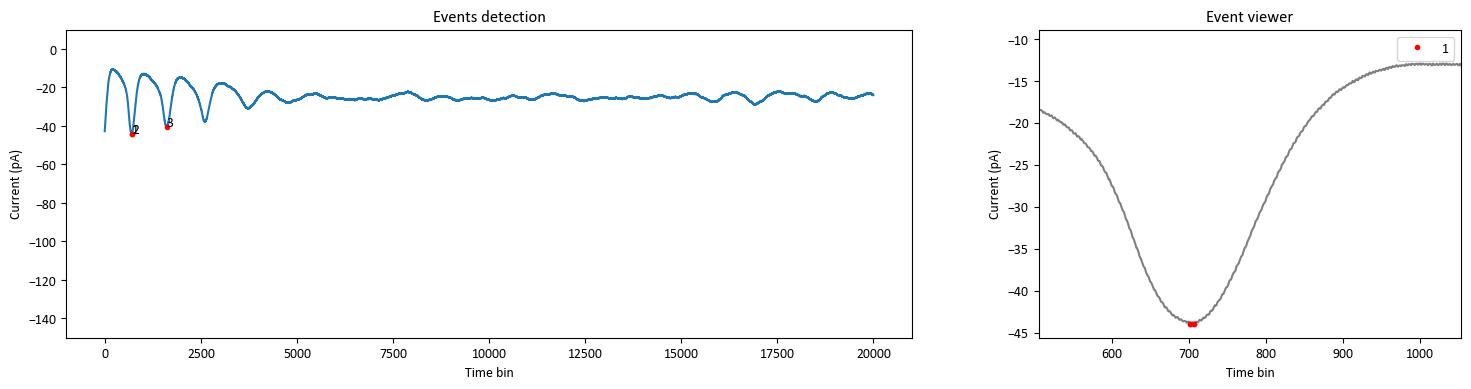

  Sweep 8: Found 3 events - stored as '2025_07_14_0033_sweep_8'


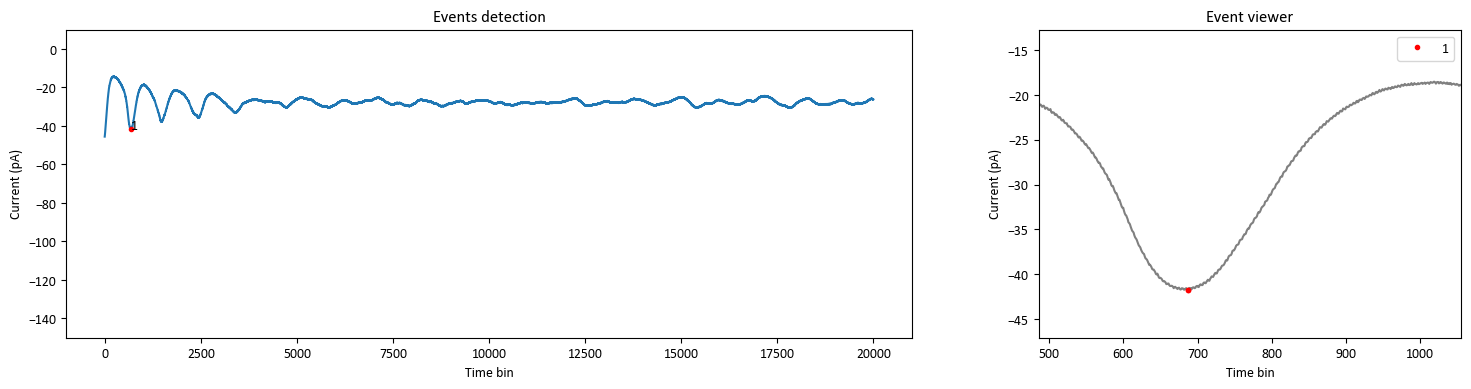

  Sweep 9: Found 1 events - stored as '2025_07_14_0033_sweep_9'
  Sweep 10: No events found or error processing - skipping '2025_07_14_0033_sweep_10'
  Sweep 11: No events found or error processing - skipping '2025_07_14_0033_sweep_11'
  Sweep 12: No events found or error processing - skipping '2025_07_14_0033_sweep_12'
  Sweep 13: No events found or error processing - skipping '2025_07_14_0033_sweep_13'

Total tables created: 25
Available table keys: ['2025_07_14_0000_sweep_5', '2025_07_14_0000_sweep_7', '2025_07_14_0000_sweep_8', '2025_07_14_0006_sweep_5', '2025_07_14_0006_sweep_6', '2025_07_14_0006_sweep_7', '2025_07_14_0006_sweep_8', '2025_07_14_0006_sweep_10', '2025_07_14_0006_sweep_11', '2025_07_14_0006_sweep_12', '2025_07_14_0006_sweep_13', '2025_07_14_0013_sweep_5', '2025_07_14_0013_sweep_6', '2025_07_14_0013_sweep_7', '2025_07_14_0013_sweep_8', '2025_07_14_0013_sweep_10', '2025_07_14_0013_sweep_11', '2025_07_14_0013_sweep_12', '2025_07_14_0013_sweep_13', '2025_07_14_0033_sweep

In [ ]:
path = r"""Z:\Omer\Ph.D\Project- Uri's sapap3ko_vs_wt_crh_cells\Data\14.07.25"""

# Dictionary to store all tables with unique keys
all_sweep_tables = {}

for file in os.listdir(path):
    if file.endswith('.abf'):
        file_size = os.path.getsize(os.path.join(path, file)) / 1024  # Size in KB
        if file_size > 4110:
            continue  # Skip files smaller than 5000 KB
        file_name = file.replace('.abf', '')  # Remove .abf extension for cleaner names
        abf = pyabf.ABF(os.path.join(path, file))
        for sweep in abf.sweepList:
            abf.setSweep(sweep, baseline=[0, 20000])
            table_key = f"{file_name}_sweep_{sweep}"
            try:
                tbl = peaks_finder(-abf.sweepY, 40, 120, 15, 50000)
                tbl['file_name'] = file_name
                tbl['sweep_number'] = sweep
                tbl['table_key'] = table_key
                
                # Store the table in the dictionary
                all_sweep_tables[table_key] = tbl
                
                print(f"  Sweep {sweep}: Found {len(tbl)} events - stored as '{table_key}'")


            except:
                print(f"  Sweep {sweep}: No events found or error processing - skipping '{table_key}'")
                all_sweep_tables[table_key] = pd.DataFrame()  # Store empty DataFrame for failed processing
                continue

print(f"\nTotal tables created: {len(all_sweep_tables)}")
print("Available table keys:", list(all_sweep_tables.keys()))               

In [14]:
all_sweep_tables['2025_07_14_0000_sweep_7']

,event,peak_index,peak_time_s,event_window_start,event_window_end,peak_amp,width_ms,inst_freq,isi_s,area,decay_tau_log,decay_tau_exp,rise_tau_exp,rise_half_amp_ms,decay_half_amp_ms,file_name,sweep_number,table_key
0,1,579,0.01158,404.785714,938.818182,60.008633,3.680649,NaN,0.00000,368.230011,5.047897,0.2,3.045827,1.484286,2.196364,2025_07_14_0000,7,2025_07_14_0000_sweep_7
1,2,1513,0.03026,1306.611111,1925.700000,52.898037,5.381778,53.533191,0.01868,466.570007,9.101562,0.2,5.782389,2.127778,3.254000,2025_07_14_0000,7,2025_07_14_0000_sweep_7
2,3,1518,0.03036,1306.611111,1925.700000,52.898037,5.381778,10000.000000,0.00010,466.570007,9.070806,0.2,5.906224,2.227778,3.154000,2025_07_14_0000,7,2025_07_14_0000_sweep_7


In [ ]:
for key, table in all_sweep_tables.items():
    